#Sentiment Analysis

Sentiment analysis (a.k.a opinion mining), in its simple form, identifies whether a piece of text has negative or positive emotion.
Sentiment analysis is a supervised learning task, where our algorithm learns how to classify text as positive/negative from labeled textual data.
There can be more than two sentiments (e.g., neutral, happy, etc.), in which case we deal with a text classification task with multiple outcomes.

Sentiment analysis is used in various business applications involving textual data, such as performance monitoring (based on user feedback), assessing brand reputation, market research for product launches.


## Scenario
We will use a dataset on restaurant reviews for this exercise. The
sentiment for each review has been manually labeled for this dataset: positive=1, negative=0.

In [ ]:
# importing restaurant reviews dataset
import numpy as np
import pandas as pd
df=pd.read_csv('Restaurant_Reviews.tsv',delimiter="\t")
df.head(3)

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0


In [ ]:
X=df.Review
Y=df.Sentiment
X.shape

(1000,)

#Sentiment Analysis using BOW approach and ML models
We will first use the bag-of-words approach for text processing and classic ML models such as Logistic Regression.

## Text pre-processing

First, we need to pre-process the text data.
We use another library this time for the pre-rocessing steps.

The *TfidfVectorizer* function lower-cases all words, removes punctuations and stopwords, tokenizes the documents, and derives the tf-idf document-term matrix.
When we fit it on our corpus it also derives the vocabulary.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# to include n-grams, change the ngram_range below
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 1), stop_words='english',sublinear_tf=True)
X_tfidf = tfidf.fit_transform(X).toarray()
X_tfidf.shape

(1000, 1820)

In [ ]:
# Let's take a look at a review and its tokens from the tf-idf matrix
print(X[17]),
tfidf.inverse_transform(X_tfidf[17])

Waitress was a little slow in service.


ValueError: ignored

In [ ]:
# number of tokens in each document (review) of our corpus
num_tokens = [np.count_nonzero(tokens) for tokens in X_tfidf]
num_tokens[17]

4

In [ ]:
# number of words in our vocabulary
num_words=len(tfidf.vocabulary_)
num_words

1820

## Split the data into test/train
We split the tranformed data (i.e, the tf-idf doc-term matrix) into testing and training set. I keep a small part for the testing set here.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.20,random_state=123)

## ML models for text classification
Our outcome is binary (positive/negative), so we will try Logistic Regression, Naive Bayes, and multinomial Naive Bayes (good choice for text classification with multiple outcomes).

We train all these models using k-fold Cross validation on the training set (X_train).
For each run in our k-fold CV, X_train is split into a training and validation set. We will use the testing set (X_test) in the next part to evaluate the selected model.

For more details on *Multinomial Naive Bayes* and its comparison to Naive Bayes, see https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes and
https://stats.stackexchange.com/questions/33185/difference-between-naive-bayes-multinomial-naive-bayes

LogisticReg: 0.771250 (0.034369)
NaiveBayes: 0.690000 (0.023914)
MultinomialNB: 0.770000 (0.026634)


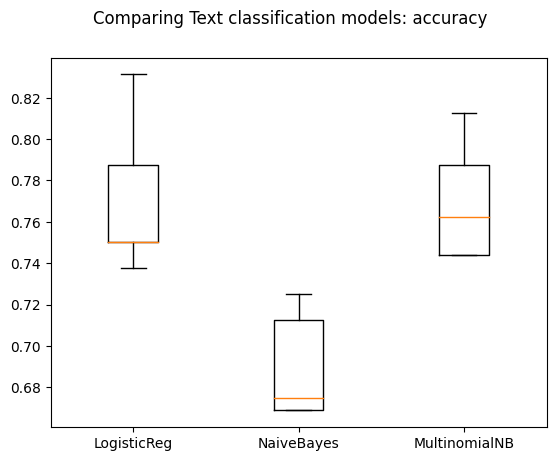

In [ ]:
#import warnings
#warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.svm import SVC

# prepare models
models = []
models.append(('LogisticReg', LogisticRegression()))
models.append(('NaiveBayes', GaussianNB()))
models.append(('MultinomialNB', MultinomialNB()))
#models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy' #metric we want to compare

for name, model in models:
	kfold = model_selection.KFold(n_splits=5,shuffle=True, random_state=0)
 #use X_tfidf, Y  in following line to run on complete dataset #X_train,y_train
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot model comparison
fig = plt.figure()
fig.suptitle('Comparing Text classification models: ' +scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Question 1
Which model has a better accuracy in labeling negative/positive reviews?

Answer: Logisitic regression model.

### Question 2
Derive the vocabulary again, and this time include 2-grams (go back to Text pre-processing section, include 2-grams and re-run the steps till the above cell). Does it improve predictive performance for any of the above modelsy?

Answer: Yes, it improves the predictive performance.

## Evaluating Logistic Regression classifer  on test data

Let's pick the logistic regression classifier and evaluate it on the test set.

In [ ]:
# Logistic regression
model_LogReg = LogisticRegression(random_state=0)
model_LogReg.fit(X_train, y_train)

#y_pred_proba = model_LogReg.predict_proba(X_test)
y_pred = model_LogReg.predict(X_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Accuracy: 0.795
Balanced Acc.: 0.7957393483709273


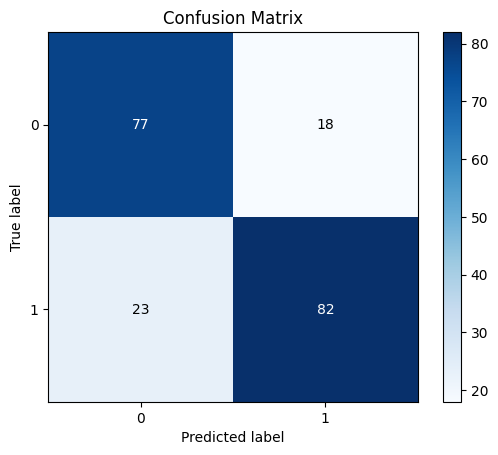

In [ ]:
!pip install scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)), #Accuracy
print("Balanced Acc.:",metrics.balanced_accuracy_score(y_test, y_pred))

## Label a new review using the logistic regression model

In [ ]:
# label a new review using our model
new_review= ['food can be better']
#process new review into doc-term matrix
X_new=tfidf.transform(new_review)
X_new

<1x1820 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [ ]:
print(model_LogReg.predict_proba(X_new)) #predict class probabilities
print(model_LogReg.predict(X_new)) #predict outcome class

[[0.59621978 0.40378022]]
[0]


### Question 3
Does the model label the new input as negative or positive?

Answer: Here the model labels the new input as negative.

# Sentiment analysis using word embeddings and RNNs (LSTM/GRU)


In [ ]:
import tensorflow.keras as tk
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Bidirectional,RNN
tk.__version__

'2.12.0'

## Preprocessing text data for RNN
To use Recurrent neural network architectures for text classification, we need to pre-process text data little differently from what we did above.
* We create a vocabulary by tokenizing all document in our corpus.
* Then, we sequence each document into integer-tokens using the derived vocabulary.
* To correctly feed each document input to the RNN, each sequenced document has to have the same length. Therefore, we pad/truncate documents.
* We use an embedding layer to convert the integer-vectors into real-valued vectors (more details in section below)
* The output of the embedding layer is fed into our Recurrent NN


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer #removes punctuations and lower-cases all words before tokenizing
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Why am I not using all the pre-processing steps here?!

In [ ]:
import gensim
from gensim.parsing.preprocessing import remove_stopwords,strip_tags,strip_multiple_whitespaces,strip_punctuation
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
tmp=X.apply(strip_multiple_whitespaces)
tmp=tmp.apply(str.lower)
tmp=tmp.apply(strip_punctuation)

In [ ]:
tmp[98]

'it was not good '

In [ ]:
tmp.apply(remove_stopwords)[98]
#tmp.apply(WordNetLemmatizer().lemmatize)[29]

'good'

### Tokenizing, sequencing, padding

In [ ]:
# using the tf.keras tokenizer
num_words=1800 #number of words to keep in vocabulary, most common words are kept
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)

In [ ]:
len(tokenizer.word_index) # total number of unique words in our corpus
#tokenizer.word_index # run to see what integer is assigned to each word after tokenization

2071

In [ ]:
# sequencing our text data (tokenizing based)
X_tokens=tokenizer.texts_to_sequences(X)

In [ ]:
# some values we need for the next step
num_tokens= np.array([np.count_nonzero(tokens) for tokens in X_tokens]) #number of tokens in each document
max_tokens=max(num_tokens)
max_tokens,num_words

(32, 1800)

In [ ]:
# pad the token sequence for each document so that all documents are of equal length
X_tokens_pad = pad_sequences(X_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')
X_tokens_pad.shape

(1000, 32)

In [ ]:
# let's see what happened to a single document at each step
print(X[17]) #the textual data
print(X_tokens[17]) #the tokenized sequence
print(X_tokens_pad[17]) #the padded sequence

Waitress was a little slow in service.
[203, 4, 5, 168, 153, 14, 17]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 203   4   5 168 153  14  17]


## Splitting the processed data into train/test

In [ ]:
# split processed data into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tokens_pad, Y, test_size=0.2,random_state=123)

In [ ]:
X_train.shape, X_test.shape, y_train.shape

((800, 32), (200, 32), (800,))

### Question 4
How many words does the longest document in X_train have?

How about the longest document in X_test?

Answer: 32 tokens each in longest documents in X_train and X_test.

## Recurrent neural network 1
The first layer is an embedding layer that converts the integer-tokens into vector values.
This is needed since the integer-tokens (X_tokens) can have values between 0 and 1800 (for our vocabulary of 1800 words), but the RNN cannot work with such wide range. The learned vector values range from -1 to 1.

The embedding-layer is trained as part of the RNN and learns to map words with similar meaning to similar embedding vectors. We will try an example below.

In [ ]:
embedding_size=16 #size of the embedding vector

model_RNN = tk.models.Sequential()

model_RNN.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

#model_RNN.add(LSTM(units=20,dropout=0.2)) # add an LSTM layer with dropout
model_RNN.add(GRU(units=20,dropout=0.2)) #add a GRU layer

# for sequences other than time series, an RNN model can sometimes perform better if it processes a sequence both forwards and backwards.
# For example, to predict the next word in a sentence it is useful to have the context around the word.
# the Bidirectional wrapper adds such layers.
#model_RNN.add(Bidirectional(LSTM(units=16,dropout=0.2)))

model_RNN.add(Dropout(0.2)) # add a dropout layer

model_RNN.add(Dense(1, activation='sigmoid'))

optimizer=tk.optimizers.Adam() # selecting the optimizer

# compiling the model
model_RNN.compile(loss='binary_crossentropy', #mae,mse
              optimizer=optimizer,
              metrics=['accuracy'])

model_RNN.summary() # model overview

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding)  (None, 32, 16)           28800     
                                                                 
 gru (GRU)                   (None, 20)                2280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 31,101
Trainable params: 31,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# make sure the input data can be feed to the RNN
model_RNN.predict(X_train[:3])

1/1 [==============================] - 1s 643ms/step


array([[0.49968576],
       [0.4999182 ],
       [0.5032101 ]], dtype=float32)

In [ ]:
# train the RNN model
# train and test sets: using all data in train set for learning and test set for validation
history = model_RNN.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, verbose=1)
# train, validate, test sets: further splitting training set into train/validation
#history = model_RNN.fit(X_train, y_train,validation_split=0.2,epochs=10, verbose=1)

Epoch 1/10
25/25 [==============================] - 3s 53ms/step - loss: 0.6921 - accuracy: 0.5150 - val_loss: 0.6895 - val_accuracy: 0.6000
Epoch 2/10
25/25 [==============================] - 0s 16ms/step - loss: 0.6840 - accuracy: 0.6988 - val_loss: 0.6848 - val_accuracy: 0.6500
Epoch 3/10
25/25 [==============================] - 0s 18ms/step - loss: 0.6621 - accuracy: 0.7875 - val_loss: 0.6648 - val_accuracy: 0.6850
Epoch 4/10
25/25 [==============================] - 0s 18ms/step - loss: 0.5814 - accuracy: 0.8163 - val_loss: 0.5767 - val_accuracy: 0.7200
Epoch 5/10
25/25 [==============================] - 0s 18ms/step - loss: 0.4215 - accuracy: 0.8413 - val_loss: 0.4704 - val_accuracy: 0.7900
Epoch 6/10
25/25 [==============================] - 0s 18ms/step - loss: 0.2864 - accuracy: 0.8975 - val_loss: 0.4759 - val_accuracy: 0.7750
Epoch 7/10
25/25 [==============================] - 0s 17ms/step - loss: 0.2027 - accuracy: 0.9663 - val_loss: 0.4103 - val_accuracy: 0.8100
Epoch 8/10
25

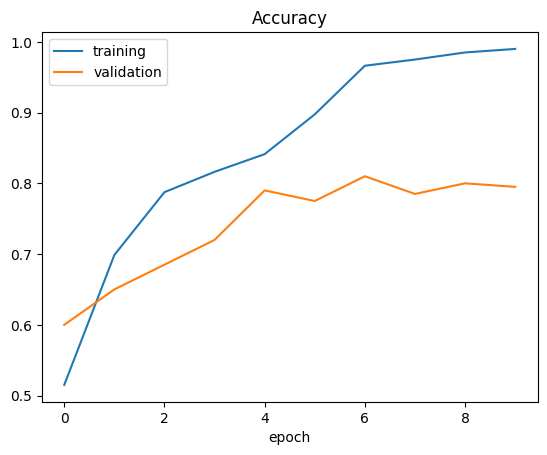

In [ ]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label="training")
plt.plot(history.history['val_accuracy'],label="validation")
plt.xlabel("epoch")
plt.title('Accuracy')
plt.legend()
plt.show()

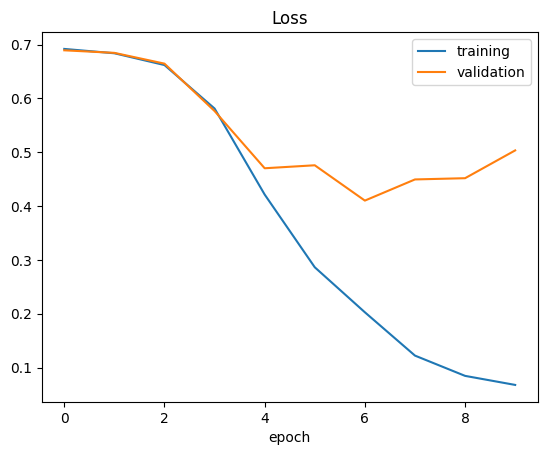

In [ ]:
# plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label="training")
plt.plot(history.history['val_loss'],label="validation")
plt.xlabel("epoch")
plt.title('Loss')
plt.legend()
plt.show()

## Evaluate the RNN model

7/7 [==============================] - 0s 5ms/step
Accuracy: 0.795
Balanced Acc.: 0.7902255639097744


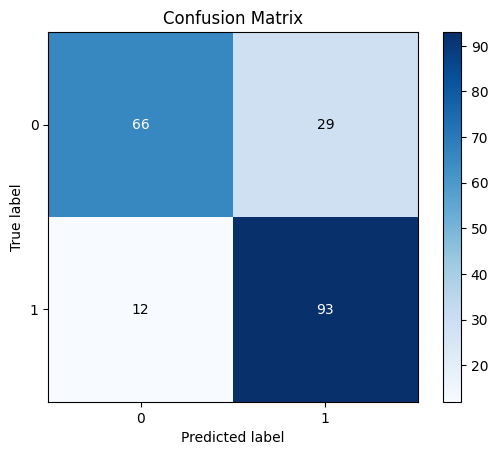

In [ ]:
y_pred=(model_RNN.predict(X_test)>0.5).astype('int32')

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)), #Accuracy
print("Balanced Acc.:",metrics.balanced_accuracy_score(y_test, y_pred))

7/7 [==============================] - 0s 6ms/step
Accuracy: 0.77
Balanced Acc.: 0.762406015037594


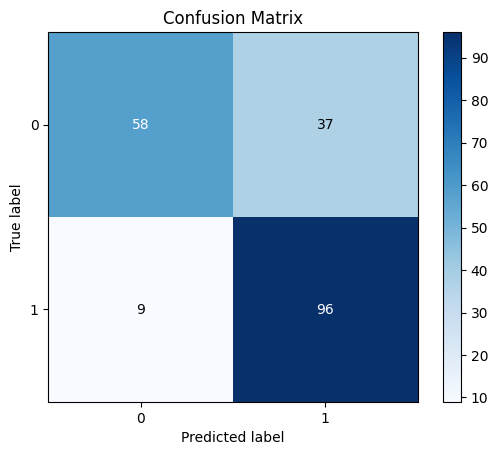

In [ ]:
y_pred=(model_RNN.predict(X_test)>0.5).astype('int32')

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)), #Accuracy
print("Balanced Acc.:",metrics.balanced_accuracy_score(y_test, y_pred))

### Question 5
Would using more training-epochs improve performance? you can retrain the model to verify.

Answer: No, there will be no improve in the performance.


### Question 6
Is the model overfitting the training data?

Answer: No.


### Question 7
Change the LSTM layer to a GRU layer. Does the RNN with GRU units have a better performance?

Answer: Only have small better performance.

### Question 8
Would the model overfit the data if we did not include the dropout layer and dropout inside the LSTM/GRU units? you can change the network architecture and retrain it to verify.

Answer: No.



### Question 9 (optional)
Increase the size of the embedding-vectors to 64 (from 16). Does it affect model performance?

Answer: Yes, the model performance increases by a small amount.


### Question 10
Decrease the number of words in the vocabulary from 2000 to 1500. Does it affect performance?

Answer: No,it does not have any affect on performance.






### Question 11
Use 'post' for padding and truncating the sequenced tokens in pad_sequences() (*Go to the "Tokenizing, sequencing, padding" section and rerun subsequent steps*). Does it affect model performance?

Answer:No, there is No change in model performance.

## Classify a new review using the RNN

In [ ]:
new_review= ['food can be better']
new_sequence=tokenizer.texts_to_sequences(new_review) # tokenize and sequence
new_seq_pad=pad_sequences(new_sequence, maxlen=max_tokens,padding='pre') # pad it
new_seq_pad

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  11, 120,  25, 108]], dtype=int32)

In [ ]:
model_RNN.predict(new_seq_pad) # predict probability
#np.argmax(model_RNN.predict(X),axis=-1) #for multiclass outcomes
(model_RNN.predict(new_seq_pad)>0.5).astype('int32') #for binary outcomes

1/1 [==============================] - 0s 33ms/step


array([[0]], dtype=int32)

## Extracing word embeddings
Earlier we mentioned word embeddings and that we have an embedding layer which learns how to map words (in the form of integer-tokens) to vectors as we train the neural network.

The distance between two word vectors indicate their similarity and we can derive these vectors for any word in our vocabulary from the embedding layer.

We will use the cosine distance between two words. Cosine values can range from [-1,1], so the distance can range from 0 to 2 (in our complex vector space):
* close to 0: two words have the same meaning
* close to 2: two words are antonyms

For more details on cosine similarity, see https://en.wikipedia.org/wiki/Cosine_similarity

In [ ]:
# extract the embedding layer from the RNN architecture
embedding_weights=model_RNN.get_layer('layer_embedding').get_weights()[0]

# vector for a word in our vocabulary
print(tokenizer.word_index['food']) # integer for word in our vocabulary
# word vector representation as learned in the embedding layer
embedding_weights[tokenizer.word_index['food']]

11


array([ 0.00868544,  0.02120974, -0.01136015,  0.01408351,  0.01640198,
        0.00845506, -0.02200441, -0.02891872,  0.01292824, -0.03272225,
       -0.00801626, -0.00999709, -0.02261773, -0.02539949, -0.00023975,
       -0.01125952], dtype=float32)

In [ ]:
# let's calculate distance between any two words in our vocabulary
from scipy.spatial.distance import cdist
float(cdist([embedding_weights[tokenizer.word_index['delicious']]],
            [embedding_weights[tokenizer.word_index['bad']]],
            metric='cosine'))

1.9377222208637699

### Question 12
How close are the words *spaghetti* and *pizza* based on the word-vectors learned in our embedding layer?

Answer: The distance is 0.44183617458008495.

### Question 13
Is the word *delicious* more similar in meaning to *good* or *bad*?

Answer: The word delicious more similar to good becuase the distance is less when compare to bad

## Recurrent Neural Network 2

Let's try another architecture 3 LSTM layers (i.e., deep RNN) and see if it has a better predictive performance.

In [ ]:
embedding_size=16 #size of the embedding vector

model_2 = tk.models.Sequential()

model_2.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

model_2.add(LSTM(units=32, return_sequences=True,dropout=0.2))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units=16, return_sequences=True,dropout=0.2))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units=8,dropout=0.2))
model_2.add(Dropout(0.2))

model_2.add(Dense(1, activation='sigmoid')) # use softmax  for multiclass outcomes

optimizer=tk.optimizers.Adam() # selecting the optimizer

# compiling the model
model_2.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
# for multiclass outcomes use categorical_crossentropy or sparse_categorical_crossentropy
# categorical_crossentropy, when outcomes are one-hot encoded
# sparse_categorical_crossentropy, when outcomes are labeled as integers

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding)  (None, 32, 16)           28800     
                                                                 
 lstm_1 (LSTM)               (None, 32, 32)            6272      
                                                                 
 dropout_2 (Dropout)         (None, 32, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32, 16)            3136      
                                                                 
 dropout_3 (Dropout)         (None, 32, 16)            0         
                                                                 
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_4 (Dropout)         (None, 8)                

In [ ]:
# fit/train the model
history2 = model_2.fit(X_train, y_train,validation_split=0.2,epochs=30, verbose=1)
#history2 = model_2.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=30, verbose=1)

Epoch 1/30
20/20 [==============================] - 15s 108ms/step - loss: 0.6935 - accuracy: 0.4953 - val_loss: 0.6926 - val_accuracy: 0.5375
Epoch 2/30
20/20 [==============================] - 1s 39ms/step - loss: 0.6914 - accuracy: 0.5875 - val_loss: 0.6918 - val_accuracy: 0.5375
Epoch 3/30
20/20 [==============================] - 1s 43ms/step - loss: 0.6835 - accuracy: 0.6203 - val_loss: 0.6869 - val_accuracy: 0.5750
Epoch 4/30
20/20 [==============================] - 1s 40ms/step - loss: 0.6445 - accuracy: 0.6406 - val_loss: 0.6879 - val_accuracy: 0.6375
Epoch 5/30
20/20 [==============================] - 1s 64ms/step - loss: 0.5581 - accuracy: 0.7422 - val_loss: 0.6511 - val_accuracy: 0.6562
Epoch 6/30
20/20 [==============================] - 1s 68ms/step - loss: 0.4494 - accuracy: 0.8141 - val_loss: 0.6774 - val_accuracy: 0.6687
Epoch 7/30
20/20 [==============================] - 1s 46ms/step - loss: 0.3392 - accuracy: 0.8828 - val_loss: 0.6904 - val_accuracy: 0.6938
Epoch 8/30


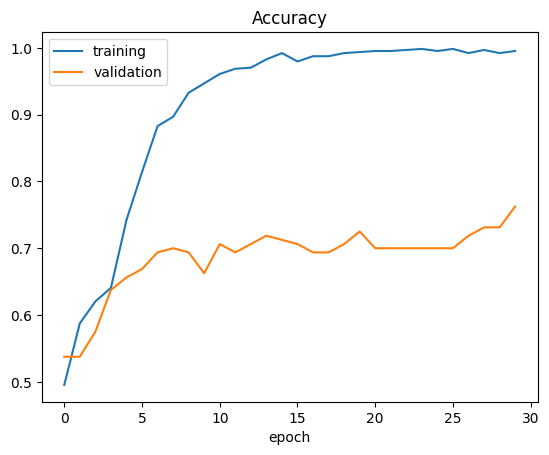

In [ ]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'],label="training")
plt.plot(history2.history['val_accuracy'],label="validation")
plt.xlabel("epoch")
plt.title('Accuracy')
plt.legend()
plt.show()

7/7 [==============================] - 1s 12ms/step
Accuracy: 0.76
Balanced Acc.: 0.7583959899749373


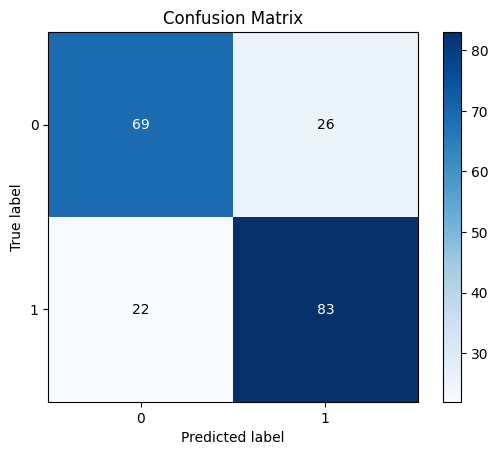

In [ ]:
# evaluate model performance on test set
y_pred=(model_2.predict(X_test)>0.5).astype('int32')

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)), #Accuracy
print("Balanced Acc.:",metrics.balanced_accuracy_score(y_test, y_pred))

###Question 14
Does the second model have better performance in terms of accuracy?

Answer: No.